In [115]:
import glob
# from slab import *
#import PyInventor
#from PyInventor import *
%load_ext autoreload
%autoreload 2
#import pyEPR as epr
#from pyEPR import ansys as HFSS
import numpy as np

%matplotlib notebook

from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm 
from matplotlib.ticker import MaxNLocator

import pandas as pd
# import pyEPR
# from pyEPR import ansys as HFSS

import scipy
from scipy import constants as const
import scipy.ndimage

#from pint import UnitRegistry
#ureg = UnitRegistry()
#Q = ureg.Quantity
import os
import matplotlib.pyplot as plt

def flt2strfmt(val, fmt='%.3f', units='mm'):
    return (fmt % val) + units

import matplotlib
import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Add junction and chip

In [2]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''

# Define the cavity parameters [mm]
z_cav_1 = 55
y_cav_1 = 25
x_cav_1 = 5
z_cav_2 = 55
y_cav_2 = 25
x_cav_2 = 5
z_offset = 0
cav_thickness = 1

# Define the coupler parameters [mmm]
z_coupler = 100.
y_coupler = 25.
x_coupler = 10.


# Offsets of the junction pads
ycoupler_offset = 0.
zcoupler_offset = 0.


# Light and heavy modes (500, 100 um)
# l_junc = 500e-3
# l_junc = 100e-3
l_junc = 0.05
coupler_pads = (x_coupler - l_junc) / 2
y_pads = 0.1
w_junc = l_junc / 2 * 1e-3

In [3]:
# Project and HFSS design names for the bare waveguide model
dd = datetime.datetime.today().strftime('%y%m%d')
ref_name = 'monolithic_pads_l_coupled_bbq_y11'
project_name=f'{ref_name}_{dd}'
design_name=f'{ref_name}_hfss_design_{dd}'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.save(full_path)
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

# Geometry parameters
zcav1 = EM_design.set_variable('z_cav_1', flt2strfmt(z_cav_1))
ycav1 = EM_design.set_variable('y_cav_1', flt2strfmt(y_cav_1))
xcav1 = EM_design.set_variable('x_cav_1', flt2strfmt(x_cav_1))
zcav2 = EM_design.set_variable('z_cav_2', flt2strfmt(z_cav_2))
ycav2 = EM_design.set_variable('y_cav_2', flt2strfmt(y_cav_2))
xcav2 = EM_design.set_variable('x_cav_2', flt2strfmt(x_cav_2))
zcpl  = EM_design.set_variable('z_coupler', flt2strfmt(z_coupler))
ycpl  = EM_design.set_variable('y_coupler', flt2strfmt(y_coupler))
xcpl  = EM_design.set_variable('x_coupler', flt2strfmt(x_coupler))
ycpl_offset = EM_design.set_variable('ycoupler_offset',
                                    flt2strfmt(ycoupler_offset))
zcpl_offset = EM_design.set_variable('zcoupler_offset',
                                    flt2strfmt(zcoupler_offset))
z_offset  = EM_design.set_variable('z_offset', flt2strfmt(z_offset))
x_cpl_offset = EM_design.set_variable('x_cpl_offset', flt2strfmt(2e3*x_cav_1))
tcav = EM_design.set_variable('cav_thickness', flt2strfmt(cav_thickness))
cpl_pads = EM_design.set_variable('coupler_pads', flt2strfmt(coupler_pads))
ypads = EM_design.set_variable('y_pads', flt2strfmt(y_pads))
ljunc = EM_design.set_variable('l_junc', flt2strfmt(l_junc))

print(f'z_offset: {z_offset}')
print(f'x_cpl_offset: {x_cpl_offset}')

# Origin
pos=[0, 0, 0]

# Draw the cavities
## Define the cavity and coupler dimensions and positions
cav1_dims = [xcav1, ycav1, zcav1]
cav2_dims = [xcav1+tcav, ycav1+tcav, zcav1+tcav]
cav1_pos = [0, ycav1/2, zcav1/2]
cpl_dims = [xcpl, ycpl, zcpl/2]
cplout_dims = [xcpl+tcav, ycpl+tcav, zcpl/2+tcav]
cpl_pos = [0, 0, 0]
cav2_dims = [xcav2, ycav2, zcav2]
cav2_pos = [0, ycav1+ycpl+ycav2/2, zcav1/2]

# cav1 = model.draw_box_center(cav1_pos, cav1_dims, name='cavity_1')
pad1_pos = [-cpl_pads/2-ljunc/2, ycpl_offset, zcpl_offset]
pad2_pos = [cpl_pads/2+ljunc/2, ycpl_offset, zcpl_offset]

pad_dims = [cpl_pads,  ypads, xcpl/10]
cpl  = model.draw_box_center(cpl_pos, cpl_dims, name='coupler')
pad1 = model.draw_box_center(pad1_pos, pad_dims, name='pad1')
pad2 = model.draw_box_center(pad2_pos, pad_dims, name='pad2')

# PEC cavity subtraction and realization
# cplout  = model.draw_box_center(cpl_pos, cplout_dims, name='coupler_outer')
# model.subtract(cplout, [cpl], keep_originals=True)
# model.assign_material(cplout, material='pec')

# cav2 = model.draw_box_center(cav2_pos, cav2_dims, name='cavity_2')

# Seed mesh for coupler box before uniting with cavities
# model.mesh_length(name_mesh='cpl', objects=[cpl], 
#                  max_length='%.3fum'%200)

#cavity = model.unite(names=['cavity_1', 'cavity_2','coupler'], 
#                     keep_originals=False)

model.subtract(cpl, [pad1, pad2], keep_originals=False)

junc_loc = [0, ycpl_offset, zcpl_offset]
jj=model.draw_rect_center(pos=junc_loc, x_size=xcpl-2*cpl_pads,
                          y_size=0,
                          z_size = w_junc,
                          name='jj')

project_name: monolithic_pads_l_coupled_bbq_y11_220530
path: Z:\tcav\ipynbs\HFSS\monolithic_pads_l_coupled_bbq_y11_220530.aedt


C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:486: UserWarning: No project in path of name: monolithic_pads_l_coupled_bbq_y11_220530.aedt
C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:487: UserWarning: Creating new project ...


z_offset: z_offset
x_cpl_offset: x_cpl_offset


In [4]:
# model.assign_perfect_E([pad_1, pad_2], name='TPads')
Lj_val=10.  #<---this sets the nominal Lj_val, should be same as start
L_jj=EM_design.set_variable('Lj_1', '%.3fnH'%Lj_val)
jj_line=model.draw_polyline(jj.make_center_line(axis='X'), 
                            closed=False, name='jj_line')

### Change solution type to Driven Modal before assigning the lumped port

In [5]:
jj.make_lumped_port('X', z0=1e6)

## Postprocessing, blackbox quantization

In [3]:
def get_wp_Cp_Lp(f, y, LJ0=10e-9, CJ0=2e-15, fscale=1e9, use_Zq=False):
    """
    Converts frequency-dependent imaginary parts
    of the admittance data to poles,
    capacitances, and inductances
    """
    # Add the junction inductance and capacitance to the
    # total admittance
    # Compute the zero crossings
    fcpy = np.copy(f * fscale)
    ycpy = np.copy(np.complex128(y))
    if LJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
          + 1j * fcpy * 2 * np.pi * CJ0
    
    yim = ycpy.imag
    zero_xing_idxs = np.where(np.diff(np.sign(yim)))[0]
    wp = 2 * np.pi * fcpy[zero_xing_idxs]
    yp = yim[zero_xing_idxs]

    # Compute the capacitances from the derivatives
    ypp = np.gradient(ycpy, 2*np.pi*(fcpy[1]-fcpy[0]))
    Cp = 0.5 * np.abs(ypp.imag[zero_xing_idxs])
    Lp = 1. / (wp**2 * Cp)
    Zp = np.sqrt(Lp / Cp)
    
    # Physical constants
    h    = 6.62607015e-34 
    hbar = h / (2 * np.pi)
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    
    # Compute Ej, Ec
    if LJ0 and CJ0:
        # Compute the Josephson inductive and charging energies
        Ej = (Phi0 / (2 * np.pi))**2 / LJ0
        Ec = e**2 / (2 * CJ0)

        # Compute inductive energies, EL
        EL = 0.5 * Phi0**2 / Lp

        # Compute the phase zero point fluctuations
        GQ = 2 * e**2 / h
        phip2 = 2 * np.pi * GQ * Zp

        # Compute the participations
        # p = phi2 * 2 * Ej / (hbar * wp)
        pl = Lp / LJ0
        pc = Cp / CJ0

        # Compute the gs / Ds
        Zq = np.sqrt(LJ0 / CJ0)
        gD = np.sqrt(Zp / Zq)

        # Compute the chis, anharmonicities
        # In units of Hz
        chipp  = -Ec * gD**2 / h
        chippp = np.asarray([-2 * np.sqrt(chipp[p] * chipp[q]) 
                             for p in range(len(chipp))
                             for q in range(len(chipp))])
        chippp = chippp.reshape([len(chipp), len(chipp)])

        return wp, Lp, Cp, fcpy, ycpy, yp, pl, pc, gD, chippp
    
    else:
        return wp, Lp, Cp, fcpy, ycpy, yp, None, None, None, None

In [4]:
## Load the data manually exported from HFSS Y-parameter plots

# Load the data from file, combine as one wide frequency sweep
yredata = []
yimdata = []
fdata = []
# Set the directories and name the files in a sane fashion
# dstr = '220205'
# dstr = '211217'
# dstr ='220511'
# dstr ='220513'
dstr = '220531'
data_prefix = f'../data/y11_monolithic_pads'
data_prefix = '../data/y11_ycpl_sweep'
data_prefix = '../data/y11_zcpl_ycpl_sweep'

# data_prefix = '../data/y11_zcpl_sweep'
is_zcpl_offset = False
# is_zcpl_offset = True
is_ycpl_offset = False
is_zycpl_offset = True
# is_ycpl_offset = False
fswp1 = f'{data_prefix}_5_25GHz_50um_offset_{dstr}.csv'
fswp1 = f'{data_prefix}_2_20GHz_{dstr}.csv'
# fswp1 = f'{data_prefix}_5_25GHz_50um_{dstr}.csv'

# Iterate over all of the files

# JJ position sweep unraveling
data = np.genfromtxt(fswp1, delimiter=',', skip_header=1).T

if is_zcpl_offset:
    xdata = np.unique(data[0])
    fdata = np.unique(data[1])
    yredata = data[2].reshape(xdata.size, fdata.size)
    yimdata = data[3].reshape(xdata.size, fdata.size)
    xscale = z_coupler / 4
elif is_ycpl_offset:
    xdata = np.unique(data[0])
    fdata = np.unique(data[1])
    yredata = data[2].reshape(xdata.size, fdata.size)
    yimdata = data[3].reshape(xdata.size, fdata.size)
    xscale = y_coupler / 2
elif is_zycpl_offset:
    zdata = np.unique(data[0])
    ydata = np.unique(data[1])
    fdata = np.unique(data[2])
    yredata = data[3].reshape(zdata.size, ydata.size, fdata.size)
    yimdata = data[4].reshape(zdata.size, ydata.size, fdata.size)
else:
    filenames = [fswp1]
    for f in filenames:
        data = np.genfromtxt(f, delimiter=',', skip_header=1).T
        fdata.append(data[0])
        yredata.append(data[1])
        yimdata.append(data[2])   

# Combine and flatten the data
# fdata = np.asarray(fdata).flatten()
# yredata = np.asarray(yredata).flatten()
#yimdata = np.asarray(yimdata).flatten()
yydata = yredata + 1j * yimdata

yydata.shape

(13, 13, 20001)

In [5]:
zdata

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [6]:
ydata

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.])

In [7]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

In [8]:
def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

In [9]:
def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

In [89]:
def fix_outlier_pixels(data, tolerance=10, worry_about_edges=True):
    """
    This function finds the hot or dead pixels in a 2D dataset. 
    tolerance is the number of standard deviations used to cutoff the hot pixels
    If you want to ignore the edges and greatly speed up the code, then set
    worry_about_edges to False.
    
    The function returns a list of hot pixels and also an image with with hot pixels removed
    
    Code acquired from:
    
    https://stackoverflow.com/questions/18951500
    /automatically-remove-hot-dead-pixels-from-an-image-in-python
    
    """
    # Apply the median filter to the image, subtract the result from the data
    from scipy.ndimage import median_filter
    blurred = median_filter(data, size=2)
    difference = data - blurred
    threshold = tolerance*np.std(difference)

    #find the hot pixels, but ignore the edges
    hot_pixels = np.nonzero((np.abs(difference[1:-1,1:-1])>threshold) )
    hot_pixels = np.array(hot_pixels) + 1 #because we ignored the first row and first column

    fixed_image = np.copy(data) #This is the image with the hot pixels removed
    for y,x in zip(hot_pixels[0],hot_pixels[1]):
        fixed_image[y,x] = blurred[y,x]

    if worry_about_edges == True:
        height,width = np.shape(data)

        ###Now get the pixels on the edges (but not the corners)###

        #left and right sides
        for index in range(1,height-1):
            #left side:
            med  = np.median(data[index-1:index+2,0:2])
            diff = np.abs(data[index,0] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[index],[0]]  ))
                fixed_image[index,0] = med

            #right side:
            med  = np.median(data[index-1:index+2,-2:])
            diff = np.abs(data[index,-1] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[index],[width-1]]  ))
                fixed_image[index,-1] = med

        #Then the top and bottom
        for index in range(1,width-1):
            #bottom:
            med  = np.median(data[0:2,index-1:index+2])
            diff = np.abs(data[0,index] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[0],[index]]  ))
                fixed_image[0,index] = med

            #top:
            med  = np.median(data[-2:,index-1:index+2])
            diff = np.abs(data[-1,index] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[height-1],[index]]  ))
                fixed_image[-1,index] = med

        ###Then the corners###

        #bottom left
        med  = np.median(data[0:2,0:2])
        diff = np.abs(data[0,0] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[0],[0]]  ))
            fixed_image[0,0] = med

        #bottom right
        med  = np.median(data[0:2,-2:])
        diff = np.abs(data[0,-1] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[0],[width-1]]  ))
            fixed_image[0,-1] = med

        #top left
        med  = np.median(data[-2:,0:2])
        diff = np.abs(data[-1,0] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[height-1],[0]]  ))
            fixed_image[-1,0] = med

        #top right
        med  = np.median(data[-2:,-2:])
        diff = np.abs(data[-1,-1] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[height-1],[width-1]]  ))
            fixed_image[-1,-1] = med

    return hot_pixels, fixed_image

In [116]:
def plot_2d_cmap(x, y, z, fname,                                                
                 xstr='', ystr='',                                              
                 tstr='', cbar_str='',                                          
                 cmap=cm.inferno,
                 xyscales={'x' : 'linear', 'y': 'linear'},
                 interp_zeros=False,
                interp_std_dev=10,
                image_rot_angle=0,
                norm_type='linear'):
    """                                                                         
    Plot 2D colormap data such that                                             
                                                                                
         -----------------------                                                
         |                     |                                                
         |                     |                                                
    y    |          z          |                                                
         |                     |                                                
         |                     |                                                
         -----------------------                                                
                                                                                
                    x                                                           
                                                                                
    Parameters:                                                                 
    ----------                                                                  
                                                                                
    x, y:       independent variables                                           
    z:          resulting data, z = z(x, y)                                     
    fname:      output figure filename, relative path with file extension       
    xstr:       x-axis label                                                    
    ystr:       y-axis label                                                    
    tstr:       title label                                                     
    cbar_str:   lable for color bar                                             
    cmap:       colormap to use on the 2D figure output                         
                                                                                
    """
    # Interpolate the data
    if interp_zeros:
        hot_pixels, z = fix_outlier_pixels(z, tolerance=interp_std_dev)
    
    # Setup the color map, normalizations, etc  
    if norm_type == 'linear':
        norm = mpl.colors.Normalize(z.min(), z.max())
    elif norm_type == 'log':
        norm = mpl.colors.LogNorm(z.min(), z.max())
    else:
        raise ValueError(f'norm_type ({norm_type}) not recognized.')
        
    # Fontsize                                                                  
    fsize = 24; tsize = 26;                                                     
                                                                                
    # Setup the figure and axes                                                 
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)            
    levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    if image_rot_angle:
        z = scipy.ndimage.rotate(z, image_rot_angle, reshape=True
)
    plt1 = ax.imshow(z, cmap=cmap, norm=norm)
    ax.set_xlabel(xstr, fontsize=fsize)                                         
    ax.set_ylabel(ystr, fontsize=fsize)                                         
    ax.set_title(tstr, fontsize=tsize)
    
    ax.set_xticks(np.arange(len(x), dtype=int))
    ax.set_yticks(np.arange(len(y), dtype=int))
    ax.set_xticklabels([f'{xx:.2f}' for xx in x])
    ax.set_yticklabels([f'{xx:.2g}' for xx in y[::-1]])
    #ax.set_xscale(xyscales['x'])
    #ax.set_yscale(xyscales['y'])
    set_xaxis_rot(ax, 45)
                                                                                
    # Set the axis tick labels to a reasonable size                             
    set_axes_fonts(ax, fsize)                                                   
                                                                                
    # Set the color bar, offset the title slightly from top                     
    cbar = fig.colorbar(plt1, ax=ax)                                            
    cbar.ax.set_title(cbar_str, fontsize=fsize, y=1.025)                        
    cbar.ax.tick_params(labelsize=fsize)                                        
                                                                                
    # Write the results to file                                                 
    fig.savefig(fname, format='pdf', transparent=True)                  

In [117]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
"""
for y in ydata:
    wp, Lp, Cp, fcpy, ycpy, yp, pl, pc, gD, chippp = \
    get_wp_Cp_Lp(fdata, y, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)

    fig, ax = plt.subplots(1, 1, tight_layout=True)
    ax.plot(fdata, y.imag)
    ax.plot(wp/(2*np.pi*fscale), yp.imag, 'o', label='Zero Crossings')
    ax.set_ylabel(r'$\Im Y(\omega)$', fontsize=fsize)
    ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
    set_axes_fonts(ax, fsize)
    # fig.savefig(f'../figs/zeros_term_bbq_inductive_50um_{dstr}.pdf', format='pdf')
"""

"\nfor y in ydata:\n    wp, Lp, Cp, fcpy, ycpy, yp, pl, pc, gD, chippp =     get_wp_Cp_Lp(fdata, y, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)\n\n    fig, ax = plt.subplots(1, 1, tight_layout=True)\n    ax.plot(fdata, y.imag)\n    ax.plot(wp/(2*np.pi*fscale), yp.imag, 'o', label='Zero Crossings')\n    ax.set_ylabel(r'$\\Im Y(\\omega)$', fontsize=fsize)\n    ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)\n    set_axes_fonts(ax, fsize)\n    # fig.savefig(f'../figs/zeros_term_bbq_inductive_50um_{dstr}.pdf', format='pdf')\n"

## Iterate over all coupler offset values, fix LJ=10 nH

In [173]:
NLJ = 13
wps = []
pcs = []
pls = []
gDs = []
Cps = []
Lps = []
chis = []
Nmodes = 6
widx = 5

# Whether or not to use the largest impedance mode
# as the junction mode in the calculations
use_Zq = False
print_results = False

LJs = np.linspace(10e-9, 100e-9, NLJ)
LJ0 = 10e-9
# for LJ0 in LJs:
for idz, z in enumerate(zdata):
    # idy = 0
    for idy, y in enumerate(ydata):
    #    idz = 0
        wpp, Lp, Cp, _, _, _, pl, pc, gD, chip \
        = get_wp_Cp_Lp(fdata, yydata[idz, idy, :], LJ0=LJ0, fscale=fscale, use_Zq=use_Zq)
        if print_results:
            print(f'wpp: {wpp}')
            print(f'Lp: {Lp}')
            print(f'Cp: {Cp}')
            print(f'pl: {pl}')
            print(f'pc: {pc}')
            print(f'chip: {chip}')
        #if len(wpp[0:Nmodes]) < Nmodes:
        #    pass
        #else:
        if len(wpp) > widx:
            wps.append(wpp[widx])
        else:
            wps.append(0.)
        pls.append(pl[0:Nmodes])
        pcs.append(pc[0:Nmodes])
        gDs.append(gD[0:Nmodes])
        Lps.append(Lp[0:Nmodes])
        Cps.append(Cp[0:Nmodes])
        chis.append(chip[0:Nmodes, 0:Nmodes])
    # wps.append(wpp)
    # print(f'LJ: {LJ}, wpp: {wpp}')
wps = np.asarray(wps).T
wps = wps.reshape([zdata.size, ydata.size])
# wps = wps.reshape([LJs.size, zdata.size])
pls  = np.asarray(pls).T
pcs  = np.asarray(pls).T
gDs = np.asarray(gDs).T
Lps = np.asarray(Lps).T
Cps = np.asarray(Cps).T
chis = np.asarray(chis).T

/home/nmaterise/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


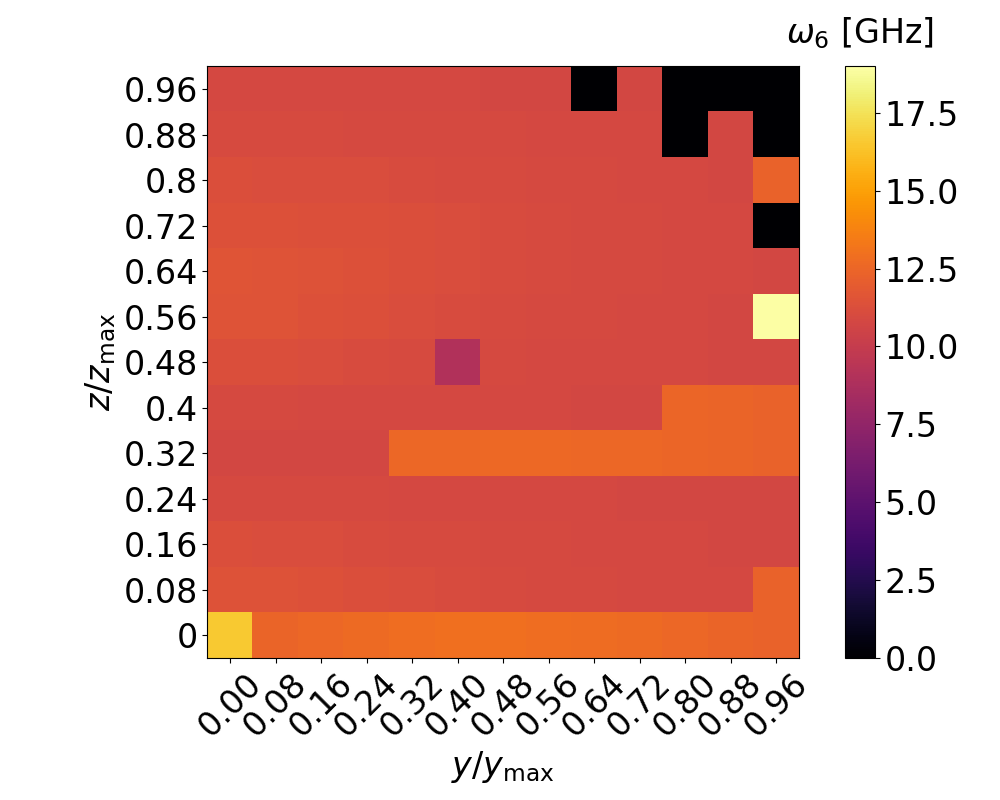

In [174]:
pref = 'dressed'
# pref = 'bare'
ymax = 25
zmax = 12.5
#plot_2d_cmap(ydata/ymax,
#    zdata/zmax,
plot_2d_cmap(# LJs/1e-9,
    ydata/ymax,
    zdata/zmax,
    wps/(2*np.pi*1e9),
    f'{pref}_mode_{widx+1}_vs_yz_{dstr}.pdf',
    xstr=r'$y / y_{\mathrm{max}}$',
    # xstr=r'$L_{J_0}$ [nH]',
    ystr=r'$z / z _{\mathrm{max}}$',
    # ystr=r'$y / y _{\mathrm{max}}$',
    tstr='',
    cbar_str=r'$\omega_{%d}$ [GHz]' % (widx+1),
    interp_zeros=False,
    interp_std_dev=3,
    image_rot_angle=90)

In [147]:
len(zdata)

13

In [89]:
len(ydata)

13

In [90]:
len(wps)

13

In [16]:
wps.shape

(169,)

<IPython.core.display.Javascript object>


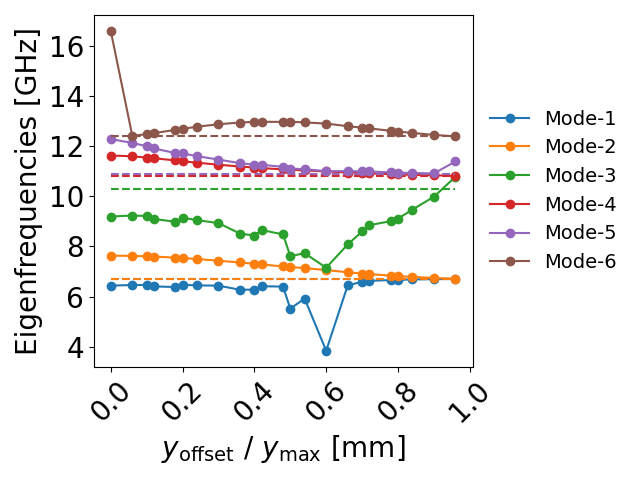

In [119]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)



ax.set_xlabel(r'$y_{\mathrm{offset}}\ /\ y_{\mathrm{max}}$ [mm]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('linear')
fig.savefig(f'../figs/modes_term_bbq_inductive_yoffset_50um_{dstr}.pdf', format='pdf')

## Blackbox participation extraction

<IPython.core.display.Javascript object>


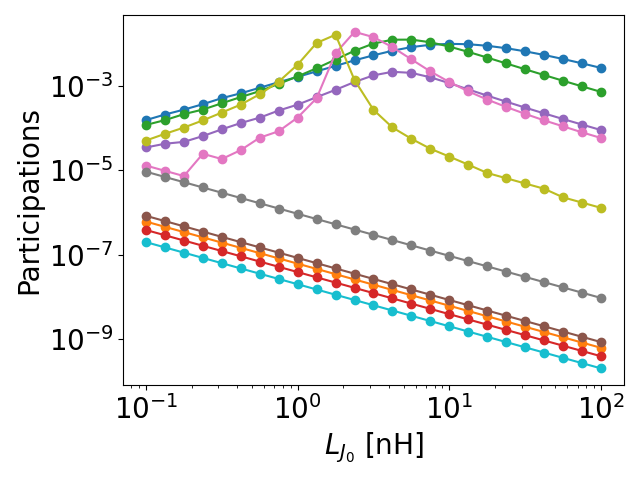

In [107]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, pp in enumerate(ps):
    ax.plot(LJs/1e-9, pp,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel('Participations', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/participations_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

## $\frac{g}{\Delta}$ From Blackbox

<IPython.core.display.Javascript object>


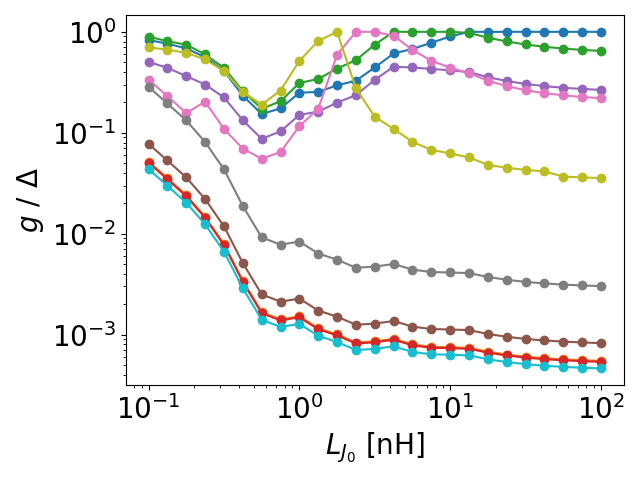

In [108]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, gg in enumerate(gDs):
    ax.plot(LJs/1e-9, gg,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$g\ /\ \Delta$', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/g_over_D_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

## $\chi$ from Black box

<IPython.core.display.Javascript object>


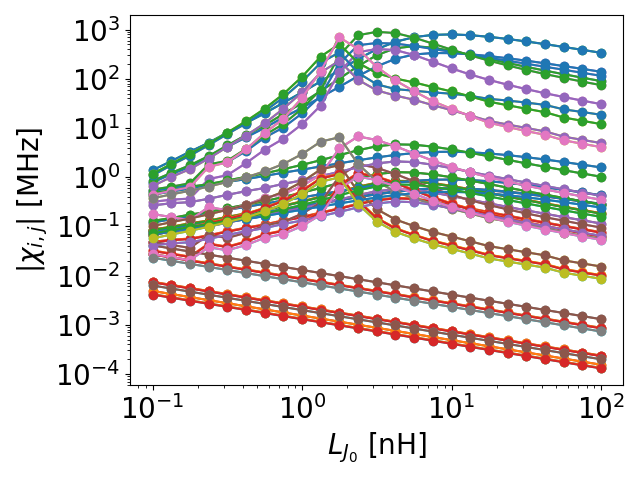

In [58]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
chi_scale = 1e6
chi_dict = {1e6: 'MHz', 1e9 : 'GHz'}
chi_str = chi_dict[chi_scale]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
M1, M2 = [Nmodes, Nmodes]
for idx1 in range(M1):
    for idx2 in range(M2):
        if idx1 != idx2:
            ax.plot(LJs/1e-9, np.abs(chis[idx1, idx2, :])/chi_scale,
            'o-', label=r'$|\chi_{%d, %d}|$' % (idx1, idx2),
            color=cycle[(idx1*Nmodes+idx2)%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\chi_{i, j}|$ [%s]' % (chi_str),
              fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/chis_bbq_inductive_50um_{dstr}.pdf',
           format='pdf')

## $\alpha$ from Black box

<IPython.core.display.Javascript object>


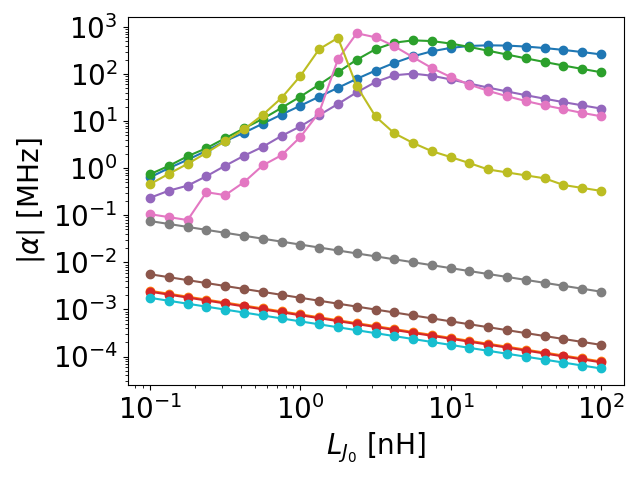

In [59]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
chi_scale = 1e6
chi_dict = {1e6: 'MHz', 1e9 : 'GHz'}
chi_str = chi_dict[chi_scale]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
M1, M2 = [Nmodes, Nmodes]
for idx1 in range(M1):
        ax.plot(LJs/1e-9, 
                0.5 * np.abs(chis[idx1, idx1, :])/chi_scale,
                'o-', label=r'$|\alpha_{%d}|$' % (idx1),
                color=cycle[idx1%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\alpha|$ [%s]' % (chi_str),
              fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/alpha_bbq_inductive_50um_{dstr}.pdf',
           format='pdf')

## Mode Capacitances, Inductances

<IPython.core.display.Javascript object>


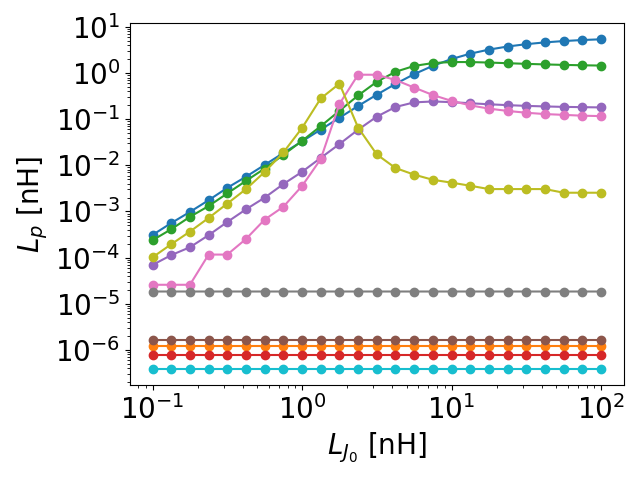

In [60]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Lppp in enumerate(Lps):
    ax.plot(LJs/1e-9, Lppp / 1e-9,
            'o-',color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$L_p$ [nH]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/Lp_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

<IPython.core.display.Javascript object>


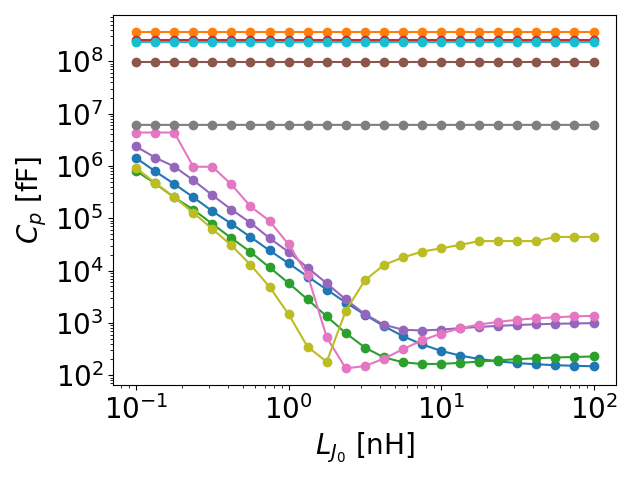

In [61]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Cppp in enumerate(Cps):
    ax.plot(LJs/1e-9, Cppp / 1e-15,
            'o-',color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$C_p$ [fF]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/Cp_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

## Mode Impedances

<IPython.core.display.Javascript object>


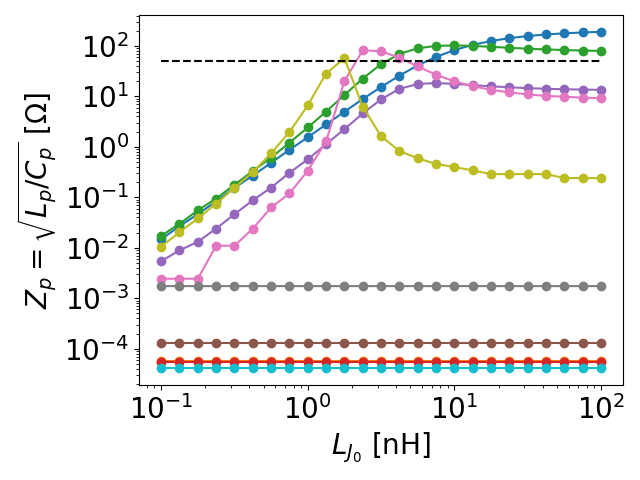

In [62]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Cppp in enumerate(Cps):
    ax.plot(LJs/1e-9, np.sqrt(Lps[idx] / Cppp),
            'o-',color=cycle[idx%clen])
ax.plot(LJs / 1e-9, [50.] * len(LJs), 'k--')
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$Z_p=\sqrt{L_p/C_p}$ [$\Omega$]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/Zp_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')